In [78]:
import pandas as pd
import numpy as np
import emoji
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math
import warnings
warnings.filterwarnings('ignore')

#### Reading datasets

In [2]:
df = pd.read_csv("D:\\Datasets\\emoji_sentiment_tweets_dataset.csv")

In [3]:
df.shape

(2000, 2)

In [4]:
df.loc[980:1010:3]

,sentiment,post
980,1,have a great
983,1,It really is uplifting and inspiring
986,1,year old i am commenting on all the new ladyli...
989,1,Just delivered my Managing the Online Customer...
992,1,well..human. That's all i
995,1,big 😍 for Anne cox 😊
998,1,thanks for the recent follow. Much appreciated...
1001,0,talking to my over driver about where I'm goin...
1004,0,There isnt a new Riverdale tonight ? 😧
1007,0,don't like how jittery caffeine makes me 😔


In [5]:
emoji_df = pd.read_csv("D:\\Datasets\\emoji_df.csv")

In [6]:
emoji_df.head(10)

,index,emoji,name,group,sub_group,codepoints
0,0,😀,grinning face,Smileys & Emotion,face-smiling,1F600
1,1,😃,grinning face with big eyes,Smileys & Emotion,face-smiling,1F603
2,2,😄,grinning face with smiling eyes,Smileys & Emotion,face-smiling,1F604
3,3,😁,beaming face with smiling eyes,Smileys & Emotion,face-smiling,1F601
4,4,😆,grinning squinting face,Smileys & Emotion,face-smiling,1F606
5,5,😅,grinning face with sweat,Smileys & Emotion,face-smiling,1F605
6,6,🤣,rolling on the floor laughing,Smileys & Emotion,face-smiling,1F923
7,7,😂,face with tears of joy,Smileys & Emotion,face-smiling,1F602
8,8,🙂,slightly smiling face,Smileys & Emotion,face-smiling,1F642
9,9,🙃,upside-down face,Smileys & Emotion,face-smiling,1F643


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2000 non-null   int64 
 1   post       2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [8]:
df.isna().sum()

sentiment    0
post         0
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

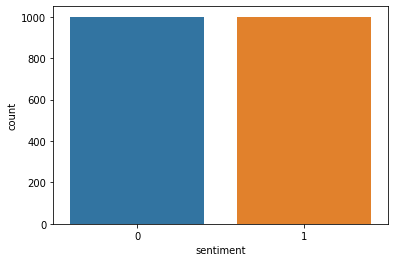

In [9]:
sns.countplot(data=df, x=df.sentiment)

In [10]:
print(f'Count of positive sentiment : {df[ df.sentiment == 1 ].shape[0]}')
print(f'Count of negative sentiment : {df[ df.sentiment == 0 ].shape[0]}')

Count of positive sentiment : 1000
Count of negative sentiment : 1000


#### Data cleaning and preprocessing step

In [11]:
# Retrive emojis list only

retrive_emojis = lambda word_list: [match["emoji"] for word in word_list for match in emoji.emoji_list(word)]

In [12]:
# Split text and emoji

def extract_text_and_emoji(text):
    global allchars, emoji_list
    # remove all tagging and links, not need for sentiments
    remove_keys = ('@', 'http://', '&', '#')
    clean_text = ' '.join(txt for txt in text.split() if not txt.startswith(remove_keys))
#     print(clean_text)
    
    # setup the input, get the characters and the emoji lists
    allchars = [str for str in text]
    emoji_list = retrive_emojis(text)
    
    # extract text
    clean_text = ' '.join([str for str in clean_text.split() if not any(i in str for i in emoji_list)])
    
    # extract emoji
    clean_emoji = ' '.join([str for str in text.split() if any(i in str for i in emoji_list)])
    return (clean_text, clean_emoji)

In [13]:
temp_df_emoji = []
temp_df_text = []

for text in df.post:
    temp_df_text.append(extract_text_and_emoji(text)[0])
    temp_df_emoji.append(extract_text_and_emoji(text)[1])
    
df["post_text"], df["emoji"] = temp_df_text, temp_df_emoji

In [14]:
df.head(10)

,sentiment,post,post_text,emoji
0,1,An inspiration in all aspects: Fashion,An inspiration in all aspects: Fashion,
1,1,fitness,fitness,
2,1,beauty and personality. 😊 😘 TheFashionIcon,beauty and personality. TheFashionIcon,😊 😘
3,1,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,😊
4,1,Beautiful album from the greatest unsung guita...,Beautiful album from the greatest unsung guita...,
5,1,Good luck to Rich riding for great project in ...,Good luck to Rich riding for great project in ...,
6,1,Omg he... kissed... him 😆 with joy,Omg he... kissed... him with joy,😆
7,1,😊 anniv ming and papi!!!!! 😍 😍 😊,anniv ming and papi!!!!!,😊 😍 😍 😊
8,1,thanks 😊,thanks,😊
9,1,C'mon Tweeps,C'mon Tweeps,


In [15]:
# convert emoji to same meaning text of emoji

def convert_emoji_to_text(emo):
    if len(emo) > 0:
        return emoji.demojize(emo)
    return ""


In [16]:
df["emoji_text"] = df.emoji.apply(convert_emoji_to_text)

In [17]:
df.head(10)

,sentiment,post,post_text,emoji,emoji_text
0,1,An inspiration in all aspects: Fashion,An inspiration in all aspects: Fashion,,
1,1,fitness,fitness,,
2,1,beauty and personality. 😊 😘 TheFashionIcon,beauty and personality. TheFashionIcon,😊 😘,:smiling_face_with_smiling_eyes: :face_blowing...
3,1,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,😊,:smiling_face_with_smiling_eyes:
4,1,Beautiful album from the greatest unsung guita...,Beautiful album from the greatest unsung guita...,,
5,1,Good luck to Rich riding for great project in ...,Good luck to Rich riding for great project in ...,,
6,1,Omg he... kissed... him 😆 with joy,Omg he... kissed... him with joy,😆,:grinning_squinting_face:
7,1,😊 anniv ming and papi!!!!! 😍 😍 😊,anniv ming and papi!!!!!,😊 😍 😍 😊,:smiling_face_with_smiling_eyes: :smiling_face...
8,1,thanks 😊,thanks,😊,:smiling_face_with_smiling_eyes:
9,1,C'mon Tweeps,C'mon Tweeps,,


In [18]:
import re
import string

NON_PUNCTUATION = r"[!\"#\$%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~0-9]"


In [19]:
def remove_punctuation(text):
    no_punctuation_text = re.sub(NON_PUNCTUATION, " ", text, 0, re.MULTILINE)
    return no_punctuation_text

df["clean_emoji_text"] = df["emoji_text"].apply(remove_punctuation)

**Remove Twitter handles:** Twitter handles start with '@' and are used to mention other users. These do not add any value to the sentiment analysis and can be removed. You can use regular expressions to remove these handles

In [20]:
def remove_twitter_handles(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)

df["clean_post"] = df["post_text"].apply(remove_twitter_handles)

**Remove URLs:** URLs are often included in tweets and can be removed as they do not contribute to sentiment analysis. You can use regular expressions to remove URLs.

In [21]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

df["clean_post"] = df["clean_post"].apply(remove_html_tags)

**Remove special characters and punctuation:** Special characters and punctuation marks can also be removed as they do not add any meaning to sentiment analysis. You can use regular expressions to remove them.

In [22]:
df["clean_post"] = df["clean_post"].apply(remove_punctuation)

**Handling abbreviations:** Twitter users often use abbreviations like "lol", "omg", etc. These can be expanded to their full form to avoid any issues with sentiment analysis. You can use dictionaries or regular expressions to expand abbreviations.

In [23]:
abbreviations = {
    'lol': 'laugh out loud',
    'lmao': 'laughing my ass off',
    'rofl': 'rolling on the floor laughing',
    'omg': 'oh my god',
    'wtf': 'what the fuck',
    'fml': 'fuck my life',
    'smh': 'shaking my head',
    'btw': 'by the way',
    'imho': 'in my humble opinion',
    'idk': 'I do not know',
    'rn': 'right now',
    'ily': 'I love you',
    'tbh': 'to be honest',
    'ig': 'I guess',
    'bae': 'before anyone else',
    'yolo': 'you only live once',
    'fomo': 'fear of missing out',
    'tmi': 'too much information',
    'afk': 'away from keyboard',
    'afaik': 'as far as I know',
    'brb': 'be right back',
    'ftw': 'for the win',
    'hmu': 'hit me up',
    'idc': 'I do not care',
    'ikr': 'I know, right?',
    'jk': 'just kidding',
    'nbd': 'no big deal',
    'np': 'no problem',
    'omw': 'on my way',
    'ppl': 'people',
    'rt': 'retweet',
    'srsly': 'seriously',
    'tbt': 'throwback Thursday',
    'tg': 'thank god',
    'tgif': 'thank god it is Friday',
    'thx': 'thanks',
    'ttyl': 'talk to you later',
    'wyd': 'what you doing?',
    'yw': 'you are welcome',
}

def handling_abbreviations(text):
    return ' '.join([abbreviations.get(word.lower(), word) for word in text.split()])

df["clean_post"] = df["clean_post"].apply(handling_abbreviations)

In [24]:
df.head(5)

,sentiment,post,post_text,emoji,emoji_text,clean_emoji_text,clean_post
0,1,An inspiration in all aspects: Fashion,An inspiration in all aspects: Fashion,,,,An inspiration in all aspects Fashion
1,1,fitness,fitness,,,,fitness
2,1,beauty and personality. 😊 😘 TheFashionIcon,beauty and personality. TheFashionIcon,😊 😘,:smiling_face_with_smiling_eyes: :face_blowing...,smiling face with smiling eyes face blowing...,beauty and personality TheFashionIcon
3,1,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,😊,:smiling_face_with_smiling_eyes:,smiling face with smiling eyes,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...
4,1,Beautiful album from the greatest unsung guita...,Beautiful album from the greatest unsung guita...,,,,Beautiful album from the greatest unsung guita...


**POS tagging** involves labeling each word in a text with its corresponding part of speech (e.g., noun, verb, adjective, etc.), which can be useful for many tasks, including sentiment analysis.

**Lemmatization:** Stemming and lemmatization can help in reducing the number of unique words and bring together words with similar meanings. You can use libraries like NLTK for stemming and lemmatization.

In [25]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
        return 'v'
    elif tag in ["JJ","JJR","JJS"]:
        return 'a'
    elif tag in ["RB","RBR","RBS"]:
        return 'r'
    else:
        return 'n'

def do_lemmatization(review):
    lemma_new = ""
    word_list = TreebankWordTokenizer().tokenize(review)
    tags = nltk.pos_tag(word_list)
    for word, tag in tags:
        if tag in ["JJ","JJR","JJS","NN","NNS","NNP","NNPS","RB","RBR","RBS","UH","VB","VBD","VBG","VBN","VBP","VBZ"]:
            word = word.lower()
            if tag in ["JJR","JJS"]:
                lemma = lemmatizer.lemmatize(word)
            lemma = lemmatizer.lemmatize(word,pos=get_pos(tag))
            lemma_new = lemma_new + " " + lemma
    return lemma_new

df["clean_post"] = df["clean_post"].apply(do_lemmatization)

In [26]:
df["clean_emoji_text"] = df["clean_emoji_text"].apply(do_lemmatization)

**Remove stop words:** Stop words are common words like "the", "is", "and", etc., which do not add any value to sentiment analysis. You can use the NLTK library to remove stop words.

In [27]:
stop_words = stopwords.words('english')

temp_stop_words = ["not","no",'do','very','don',"don't","ain","aren","aren't","couldn","couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
for sword in temp_stop_words:
    if sword in stop_words:
        stop_words.remove(sword)

#### Vectorization

In [28]:
# TFIDF vectorizer

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True,
                            strip_accents='ascii', stop_words=stop_words)

In [29]:
y = df.sentiment

X = vectorizer.fit_transform(df.clean_post +" "+ df.clean_emoji_text)

print(y.shape)
print(X.shape)

(2000,)
(2000, 2990)


#### Split the dataset into training and testing

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=6)

#### Training the model

In [31]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, KFold

In [32]:
# we will train a naive bayes classifier
m_nb = MultinomialNB()
b_nb = BernoulliNB()

m_nb.fit(X_train, y_train)
b_nb.fit(X_train, y_train)

BernoulliNB()

In [33]:
print("Multinomial Naive Bayes Algorithm")
print(f' Training accuracy is {round(m_nb.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(m_nb.score(X_test, y_test) * 100,2)}%')

print("Bernoulli Naive Bayes Algorithm")
print(f' Training accuracy is {round(b_nb.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(b_nb.score(X_test, y_test) * 100,2)}%')

y_pred_m_nb = m_nb.predict(X_test)
y_pred_b_nb = b_nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_m_nb)
print("Accuracy of MultinomialNB :", accuracy)
accuracy = accuracy_score(y_test, y_pred_b_nb)
print("Accuracy of BernoulliNB :", accuracy)

Multinomial Naive Bayes Algorithm
 Training accuracy is 96.5%
 Testing accuracy is 90.25%
Bernoulli Naive Bayes Algorithm
 Training accuracy is 95.31%
 Testing accuracy is 91.0%
Accuracy of MultinomialNB : 0.9025
Accuracy of BernoulliNB : 0.91


In [34]:
c

Confusion Matrix
[[207   9]
 [ 27 157]]


In [35]:
# Convert predictions to binary class labels
y_pred = (y_pred_b_nb > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print(report)

Classfication Report 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       216
           1       0.95      0.85      0.90       184

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



**binary cross-entropy loss** is used to measure the dissimilarity between the predicted probabilities and the true labels.

In [36]:
epsilon = 1e-15 # a very small number
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
y_pred = y_pred.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
avg_loss = np.mean(loss)
print(avg_loss)

3.1085078664841417


In [37]:


clf = BernoulliNB()

# Initialize the bagging classifier with Naive Bayes as the base estimator
bagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=10)

# Define the boosting classifier with 5 estimators
# boosting_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=10)

# Train the boosting classifier on the training set
# boosting_clf.fit(X_train, y_train)

# Fit the bagging classifier on the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the testing data
# y_pred_boost = boosting_clf.predict(X_test)

# Make predictions on the testing data
y_pred = bagging_clf.predict(X_test)

# Calculate the accuracy of the bagging classifier
accuracy = accuracy_score(y_test, y_pred)
print("Bagging Accuracy:", accuracy)

# Calculate the accuracy of the bagging classifier
# accuracy_ = accuracy_score(y_test, y_pred_boost)
# print("Boosting Accuracy:", accuracy_)

Bagging Accuracy: 0.9175


In [38]:
print('Bagging Classifier')
print(f' Training accuracy is {round(bagging_clf.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(bagging_clf.score(X_test, y_test) * 100,2)}%')

# print('Boosting Classifier')
# print(f' Training accuracy is {round(boosting_clf.score(X_train, y_train) * 100,2)}%')
# print(f' Testing accuracy is {round(boosting_clf.score(X_test, y_test) * 100,2)}%')

Bagging Classifier
 Training accuracy is 94.75%
 Testing accuracy is 91.75%


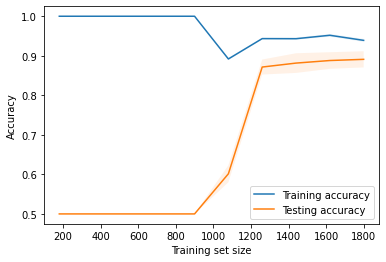

In [39]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(bagging_clf, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [40]:

# Feature selection using PCA
pca = TruncatedSVD(n_components=3)
X_new = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=6)

In [41]:
clf = BernoulliNB()

clf.fit(X_train, y_train)

BernoulliNB()

In [42]:

print(f' Training accuracy is {round(clf.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(clf.score(X_test, y_test) * 100,2)}%')

print()
y_pred = clf.predict(X_test)

print("Accuracy is ", accuracy_score(y_test, y_pred))

 Training accuracy is 84.94%
 Testing accuracy is 84.5%

Accuracy is  0.845


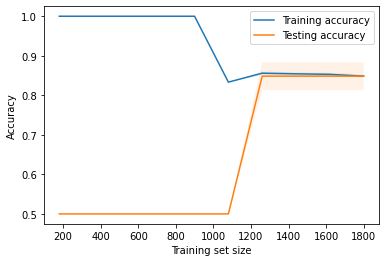

In [43]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(clf, X_new, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

##### Select best n_components for TruncatedSVD

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=6)

In [65]:
# # Define the range of n_components to evaluate
# param_grid = {'n_components': range(1,5)}

# # Perform k-fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# nb_model = TruncatedSVD()
# grid_search = GridSearchCV(nb_model, param_grid=param_grid, cv=kf, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Select the optimal number of components
# best_n_components = grid_search.best_params_['n_components']

# # Train the TruncatedSVD model on the entire training set with the best number of components
# nb_model = TruncatedSVD(n_components=best_n_components)
# # nb_model.fit(X_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
clf = BernoulliNB()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
print(sum(accuracy_scores) / len(accuracy_scores))

print(accuracy_scores)

0.892
[0.8875, 0.8875, 0.9, 0.8825, 0.9025]


#### feature selection

In [75]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest


In [124]:


mutual_info = mutual_info_classif(X, y)

# for i in range(len(mutual_info)):
#     print("Feataure", i+1, ":", mutual_info[i])

In [125]:
selector = SelectKBest(mutual_info_classif, k=int(len(mutual_info)*0.50))
X_new = selector.fit_transform(X,y)

clf = BernoulliNB()

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=6)

clf.fit(X_train, y_train)


BernoulliNB()

In [126]:

print(f' Training accuracy is {round(clf.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(clf.score(X_test, y_test) * 100,2)}%')

print()
y_pred = clf.predict(X_test)

print("Accuracy is ", accuracy_score(y_test, y_pred))

 Training accuracy is 93.06%
 Testing accuracy is 91.25%

Accuracy is  0.9125


In [127]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[209   7]
 [ 28 156]]


In [56]:
# print(f'Best n_component is : {best_n_components}')

Best n_component is : 1


In [57]:
# X_new = nb_model.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=6)

In [58]:
# clf = BernoulliNB()

# clf.fit(X_train, y_train)

BernoulliNB()

In [59]:

# print(f' Training accuracy is {round(clf.score(X_train, y_train) * 100,2)}%')
# print(f' Testing accuracy is {round(clf.score(X_test, y_test) * 100,2)}%')

# print()
# y_pred = clf.predict(X_test)

# print("Accuracy is ", accuracy_score(y_test, y_pred))

 Training accuracy is 51.5%
 Testing accuracy is 46.25%

Accuracy is  0.4625


In [60]:
# # calculate confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix")
# print(cm)

Confusion Matrix
[[  4 212]
 [  3 181]]


In [61]:
# # Calculate precision, recall, and F1-score
# report = classification_report(y_test, y_pred.astype(int))
# print("Classfication Report ")
# print(report)

Classfication Report 
              precision    recall  f1-score   support

           0       0.57      0.02      0.04       216
           1       0.46      0.98      0.63       184

    accuracy                           0.46       400
   macro avg       0.52      0.50      0.33       400
weighted avg       0.52      0.46      0.31       400



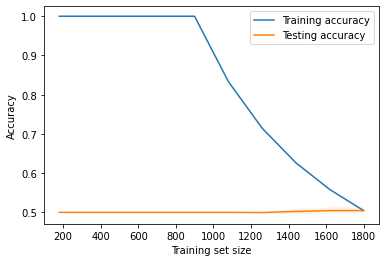

In [62]:
# # Vary the size of the training set
# train_sizes, train_scores, test_scores = learning_curve(clf, X_new, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# # Calculate the mean and standard deviation of the training and testing scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plot the learning curve
# plt.plot(train_sizes, train_mean, label='Training accuracy')
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
# plt.plot(train_sizes, test_mean, label='Testing accuracy')
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
# plt.xlabel('Training set size')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')
# plt.show()

In [63]:
# epsilon = 1e-15 # a very small number
# y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
# y_pred = y_pred.astype(float) # convert to float type
# loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
# avg_loss = np.mean(loss)
# print(avg_loss)

18.565016098902493


#### SVM

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=6)

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [129]:
print(f'Training accuracy is {round(svm_model.score(X_train, y_train) * 100,2)}%')
print(f'Testing accuracy is {round(svm_model.score(X_test, y_test) * 100,2)}%')

y_pred = svm_model.predict(X_test)
print()
print(f'Accuracy is ', accuracy_score(y_test, y_pred) )

Training accuracy is 98.25%
Testing accuracy is 90.0%

Accuracy is  0.9


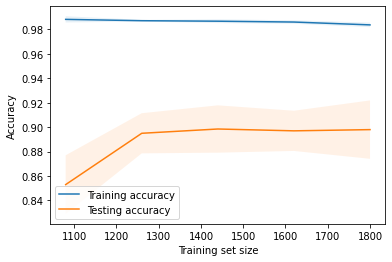

In [130]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(svm_model, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [131]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[189  27]
 [ 13 171]]


In [132]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print(report)

Classfication Report 
              precision    recall  f1-score   support

           0       0.94      0.88      0.90       216
           1       0.86      0.93      0.90       184

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [133]:
epsilon = 1e-15 # a very small number
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
y_pred = y_pred.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
avg_loss = np.mean(loss)
print(avg_loss)

3.453931612317607


In [165]:
# mutual_info = mutual_info_classif(X, y)

# selector = SelectKBest(mutual_info_classif, k=int(len(mutual_info)*0.6))
# X_new = selector.fit_transform(X,y)



In [202]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1', solver='liblinear')

sfm = SelectFromModel(logit)

X_new = sfm.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=2)

svm_model_s = SVC(kernel='linear')

svm_model_s.fit(X_train, y_train)

SVC(kernel='linear')

In [203]:
# print(rfc.feature_importances_)

In [204]:
# k=int(len(rfc.feature_importances_) /2)
# top_k_indices = rfc.feature_importances_.argsort()[-k:][::-1]
# X_train_top_k = X_train[:, top_k_indices]
# X_test_top_k = X_test[:,top_k_indices]

In [205]:
# svm_model_s.fit(X_train_top_k, y_train)

In [197]:
# svm_model_s = SVC(kernel='linear')

# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=2)

# svm_model_s.fit(X_train, y_train)

In [206]:
print(f' Training accuracy is {round(svm_model_s.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(svm_model_s.score(X_test, y_test) * 100,2)}%')

print()
y_pred = svm_model_s.predict(X_test)

print("Accuracy is ", accuracy_score(y_test, y_pred))

 Training accuracy is 91.75%
 Testing accuracy is 87.75%

Accuracy is  0.8775


In [207]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[170  48]
 [  1 181]]


In [64]:
# Initialize the bagging classifier with Naive Bayes as the base estimator
bagging_svm = BaggingClassifier(base_estimator=svm_model, n_estimators=10)

# Fit the bagging classifier on the training data
bagging_svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = bagging_svm.predict(X_test)

# Calculate the accuracy of the bagging classifier
accuracy = accuracy_score(y_test, y_pred)
print("Bagging Accuracy:", accuracy)

Bagging Accuracy: 0.905


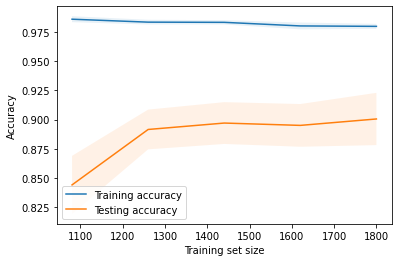

In [65]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(bagging_svm, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [219]:
from sklearn.decomposition import TruncatedSVD

# Feature selection using PCA
pca = TruncatedSVD(n_components=5)
X_new = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2,random_state=6)

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [220]:
print(f'Training accuracy is {round(svm_model.score(X_train, y_train) * 100,2)}%')
print(f'Testing accuracy is {round(svm_model.score(X_test, y_test) * 100,2)}%')

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Calculate the accuracy of the bagging classifier
accuracy = accuracy_score(y_test, y_pred)

print()
print(f'Accuracy is {accuracy}')

Training accuracy is 86.19%
Testing accuracy is 86.5%

Accuracy is 0.865


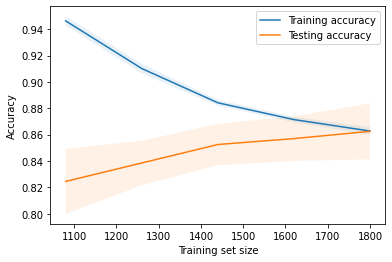

In [221]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(svm_model, X_new, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [222]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[172  44]
 [ 10 174]]


In [223]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print(report)

Classfication Report 
              precision    recall  f1-score   support

           0       0.95      0.80      0.86       216
           1       0.80      0.95      0.87       184

    accuracy                           0.86       400
   macro avg       0.87      0.87      0.86       400
weighted avg       0.88      0.86      0.86       400



In [224]:
epsilon = 1e-15 # a very small number
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
y_pred = y_pred.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
avg_loss = np.mean(loss)
print(avg_loss)

4.662822769030264


#### CNN

In [225]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout,MaxPool1D, Flatten
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2

In [226]:
def create_cnn_model(max_features):
    model = Sequential()
#     model.add(Conv1D(filters=128, kernel_size=5, activation='relu',input_shape=(max_features,1)))
#     model.add(GlobalMaxPooling1D())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1, activation='sigmoid'))

    model.add(Conv1D(256, 3, activation='relu', padding='same', input_shape=(max_features,1), kernel_regularizer=l2(0.01)))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    
    model.summary()
    
    return model

In [227]:
temp_X = df.clean_post +" "+ df.clean_emoji_text

# max_len = len(set(" ".join(X).split()))
# max_features = 1000

# TFIDF vectorizer

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True,
                            strip_accents='ascii', stop_words=stop_words)

y = df.sentiment

X = vectorizer.fit_transform(df.clean_post +" "+ df.clean_emoji_text)

print(y.shape)
print(X.shape)

(2000,)
(2000, 2990)


In [228]:
from scipy.sparse import csr_matrix

# Feature selection using PCA
# pca = TruncatedSVD(n_components=max_features)
# X_new = pca.fit_transform(X)

# X_new = csr_matrix(X_new)

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2,random_state=6)


# reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


cnn_model = create_cnn_model(X.shape[1])

cnn_model.fit(X_train, y_train, epochs=10, batch_size=128)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 2990, 256)         1024      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1495, 256)        0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 1495, 256)         0         
                                                                 
 conv1d_11 (Conv1D)          (None, 1495, 128)         98432     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 747, 128)         0         
 g1D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 747, 128)         

In [229]:
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy} and Loss : {loss}')

loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=0)
print(f'Train accuracy: {accuracy} and Loss : {loss}')

Test accuracy: 0.9125000238418579 and Loss : 0.3865605890750885
Train accuracy: 0.9962499737739563 and Loss : 0.022025613114237785


In [230]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = cnn_model.predict(X_test)

# Convert predictions to binary class labels
y_pred = (y_pred > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print(report)


Classfication Report 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       216
           1       0.93      0.88      0.90       184

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [231]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[203  13]
 [ 22 162]]


The confusion matrix shows that the model correctly classified 197 instances of the first class (usually represented as a negative class) and 163 instances of the second class (usually represented as a positive class). It misclassified 19 instances of the first class as the second class (false positives) and 21 instances of the second class as the first class (false negatives).

In [232]:
epsilon = 1e-15 # a very small number
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
y_pred = y_pred.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
avg_loss = np.mean(loss)
print(avg_loss)

ValueError: Data must be 1-dimensional

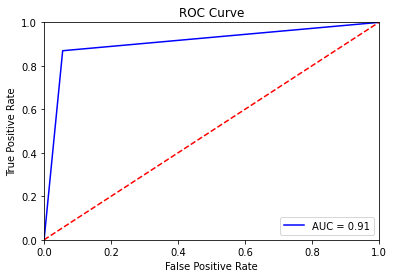

In [116]:
from sklearn.metrics import roc_curve, auc

# calculate false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [117]:
from scipy.sparse import csr_matrix

# Feature selection using PCA
pca = TruncatedSVD(n_components=max_features)
X_new = pca.fit_transform(X)

X_new = csr_matrix(X_new)

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2,random_state=6)


# reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


cnn_model = create_cnn_model(max_features)

cnn_model.fit(X_train, y_train, epochs=10, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1000, 256)         1024      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 500, 256)         0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 500, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 500, 128)          98432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 250, 128)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 250, 128)         

In [118]:
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy} and Loss : {loss}')

loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=0)
print(f'Train accuracy: {accuracy} and Loss : {loss}')

Test accuracy: 0.9049999713897705 and Loss : 0.3774769902229309
Train accuracy: 0.9850000143051147 and Loss : 0.0465228408575058


In [119]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = cnn_model.predict(X_test)

# Convert predictions to binary class labels
y_pred = (y_pred > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print(report)


Classfication Report 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       216
           1       0.92      0.87      0.89       184

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.90       400



In [120]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[202  14]
 [ 24 160]]


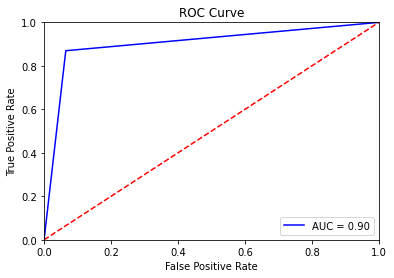

In [121]:
from sklearn.metrics import roc_curve, auc

# calculate false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()